## Deer Are Cool, Let's Protect Them
Amanda West (acw9gs), Ben Cosgro, Sean Grace

**Helpful Links:**
- https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
- https://medium.com/riga-data-science-club/geographic-coordinate-encoding-with-tensorflow-feature-columns-e750ae338b7c
- https://melvincabatuan.github.io/Keras-Tutorial-Deep-Learning-in-Python-Walkthrough/


**Random Thoughts:**
- What if we bootstrapped to make additional positive CWD cases to train the neural network?

In [289]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.optimizers import RMSprop
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# read in the data
deer = pd.read_csv("DMA1_withlatlong.csv")

In [291]:
deer = pd.read_csv("fullstategrid.csv")

In [292]:
deer.drop(columns=['Unnamed: 0'], inplace=True)
deer = deer[deer['Sample Date']<13]
deer = deer[deer['Lat_Cent']>38]
deer = deer[deer['Long_Cent']<-77]
deer.drop(columns=['Sample Date'], inplace=True)

In [293]:
test = deer.to_numpy()
test = test.reshape(12,9909,3).swapaxes(1,2).T

In [294]:
test[:,2,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [274]:
unique, counts = np.unique(test[:,2,:], return_counts=True)
dict(zip(unique, counts))

{0.0: 118843, 1.0: 65}

In [256]:
import numpy as np
#Generate 24 element 1D array and reshape to 6 rows and 4 columns
a_Array = np.arange(24).reshape(6, 4)
#reshape to distribute data along axis 2 then axis 1 and then axis 0 in order, 
#this is what numpy reshape does by default
a_Array.reshape(2,3,4)
#Swap axes 1 and 2
a_Array.reshape(2,3,4).swapaxes(1,2)
#Transpose to arrange data with data distributed along axis 1
a_Array.reshape(2,3,4).swapaxes(1,2).T

9909.0

In [173]:
deer.head(2)

,Sample Date,Lat_Cent,Long_Cent,Status
0,1,38.746075,-78.668046,0
1,1,38.745704,-78.649542,0


In [50]:
### 3 loss functions
#status
#lat
#long
#potentially convert year/month to sequential numbers

In [51]:
# reshuffle so Status is first (for x-y split a few lines down)
deer = deer[['Status', 'Sample Date', 'Lat_Cent', 'Long_Cent','Age', 'Sex', 
             'Active - Hunter Killed', 'Active - Other', 'Active - Road-Killed',
             'Targeted - Other', 'Targeted-Clinical suspect']]
deer['Sample Date'] = pd.to_datetime(deer['Sample Date'])
deer['Age'] = pd.to_numeric(deer['Age'],errors='coerce')

In [174]:
deer = deer.dropna()

<AxesSubplot:>

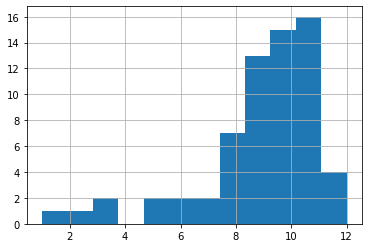

In [160]:
deer[deer['Status']==1]['Sample Date'].hist(bins=12)

In [115]:
cl = deer.iloc[:,:4] 
cl["Sample Date"] = (cl["Sample Date"]-cl["Sample Date"].min()).astype('timedelta64[Y]').astype(int)+1
cl = cl.groupby(['Sample Date', 'Lat_Cent', 'Long_Cent']).agg({'Status':['max']}).reset_index()
cl.to_csv('cl.csv')

In [195]:
cl= pd.read_csv('cl.csv')
cl.drop(columns = ['Unnamed: 0'], inplace=True)
cl = cl.iloc[1:]
cl['Sample Date']=cl['Sample Date'].astype('float64')

In [295]:
# features
#X = deer.iloc[:,1:4]  
#X = cl.iloc[:,:3]  
# without timestamp 
#X = deer.iloc[:,2:]  
X=test[:,:2,:]
# response
#y = deer.Status
#y=cl['Status']
y=test[:,2,:]

In [57]:
X["Sample Date"] = (X["Sample Date"]-X["Sample Date"].min()).astype('timedelta64[Y]').astype(int)+1
X

,Sample Date,Lat_Cent,Long_Cent
0,1,39.060983,-78.471737
1,1,39.060983,-78.471737
2,1,39.132197,-78.413342
3,1,39.004224,-78.529508
4,1,39.074248,-78.415461
...,...,...,...
10249,12,38.872635,-78.478428
10250,12,39.152780,-78.058787
10251,12,39.066813,-78.099557
10252,12,38.879436,-78.144295


In [197]:
X['Sample Date'].value_counts().head(50)

7.0     698
9.0     646
8.0     637
10.0    634
11.0    517
6.0     353
3.0     335
12.0    322
2.0     298
5.0     221
4.0     185
1.0     142
13.0     58
Name: Sample Date, dtype: int64

<AxesSubplot:>

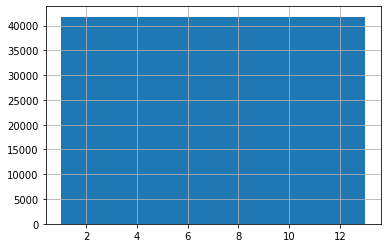

In [146]:
X['Sample Date'].hist(bins=13)

In [198]:
y=pd.DataFrame(y)
y

,Status
1,0
2,0
3,0
4,0
5,0
...,...
5042,0
5043,0
5044,1
5045,0


In [205]:
y.Status=y.Status.astype('float64')

In [218]:
X.head(2)
#X.apply(lambda x: x.astype(np.float64), axis=1)

,Sample Date,Lat_Cent,Long_Cent
1,1.0,38.831131,-78.572582
2,1.0,38.845234,-78.553561


In [ ]:
# split training data by outcome (get even class split for training data)
#X_train1 = X[y['Status']==1]
#y_train1 = y[y['Status']==1]
#X_train0 = X[y['Status']==0]
#y_train0 = y[y['Status']==0] 
#X_train0['Status'] = list(y_train0.Status)
#X_train0, _, y_train0, _ = train_test_split(X_train0, X_train0[['Status']], test_size=((X_train0.shape[0])/(X.shape[0])), random_state=2, shuffle = False)
#X_train0['Status'] = list(y_train0.Status)
#X_train1['Status'] = list(y_train1.Status)
#X_train_all = pd.concat([X_train0, X_train1])
#X_train, y_train = X_train_all.iloc[:,:-1], X_train_all[['Status']]

In [296]:
# split train & test, x & y up
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
#train, test = train_test_split(deer, test_size=0.2, shuffle=False)

In [ ]:
train = TimeseriesGenerator(train, train, length=1, sampling_rate=1, stride=1, batch_size = 5)
test = TimeseriesGenerator(test, test, length=1, sampling_rate=1, stride=1, batch_size = 5)

In [297]:
from sklearn.utils import class_weight
y_train=y_train.values.reshape(4036,)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#class_weights[0]=(class_weights[0]*1.8)
#class_weights[1]=(class_weights[1]*.2)
class_weights = {i : class_weights[i] for i in range(2)}
class_weights

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [299]:
# it doesn't like strings/objects like age and date, so we need to 
# recast these into variables that tensorflow can take as a next step
# we can also reclassify lat/long to a single crossed feature column to see
# if that improves anything (like at the top)
#X_train.info()
X_train.shape
#y_train.shape

(7927, 2, 12)

## ANN

In [245]:
# Simple neural net that DOES work (have to take out time stamp variable though, i.e. above)
# Uncomment to use

model = Sequential()
model.add(Flatten(input_shape=[3,]))
#model.add(keras.layers.BatchNormalization())
#model.add(Dense(150, activation='relu'))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(30, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## CNN-LSTM

In [ ]:
# More complex neural net (still a work in progress)
# Uncomment to use
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=6, 
                                 kernel_size=3,
                                 strides=1,
                                 activation='relu'), 
                                 batch_input_shape=(1, )+X_train.shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, stateful=True, return_sequences=True))
model.add(LSTM(10, stateful=True))
model.add(Dense(24))
model.compile(optimizer='adam', metrics=['accuracy'])

In [ ]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## Run Model

In [125]:
# note: X_train shape and input_shape must have matching # cols
print(X_train.shape)    
print(model.input_shape) 
print(model.output_shape)

(4036, 3)
(None, 3)
(None, 1)


In [182]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [251]:
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy', f1_m, precision_m, recall_m])    

In [253]:
history = model.fit(X_train, 
                    y_train,
                    epochs=50, 
                    batch_size=4,
                    class_weight=class_weights,
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6986 - accuracy: 0.7250 - f1_m: 0.0052 - precision_m: 0.0032 - recall_m: 0.0129 - val_loss: 0.7291 - val_accuracy: 0.0347 - val_f1_m: 0.0540 - val_precision_m: 0.0356 - val_recall_m: 0.1225
Epoch 2/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6983 - accuracy: 0.3484 - f1_m: 0.0115 - precision_m: 0.0072 - recall_m: 0.0287 - val_loss: 0.7306 - val_accuracy: 0.0347 - val_f1_m: 0.0540 - val_precision_m: 0.0356 - val_recall_m: 0.1225
Epoch 3/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6977 - accuracy: 0.3340 - f1_m: 0.0133 - precision_m: 0.0084 - recall_m: 0.0327 - val_loss: 0.6823 - val_accuracy: 0.9653 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6978 - accuracy: 0.5396 - f1_m: 0.0082 - precision_m: 0.0052 - recall_m: 0.0198 - val_loss: 0.7225 - val_a

Epoch 31/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6965 - accuracy: 0.2924 - f1_m: 0.0151 - precision_m: 0.0094 - recall_m: 0.0377 - val_loss: 0.6698 - val_accuracy: 0.9653 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6978 - accuracy: 0.7636 - f1_m: 0.0036 - precision_m: 0.0022 - recall_m: 0.0089 - val_loss: 0.7355 - val_accuracy: 0.0347 - val_f1_m: 0.0540 - val_precision_m: 0.0356 - val_recall_m: 0.1225
Epoch 33/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6992 - accuracy: 0.2106 - f1_m: 0.0123 - precision_m: 0.0077 - recall_m: 0.0307 - val_loss: 0.6921 - val_accuracy: 0.9653 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 34/50
1009/1009 [==============================] - 1s 1ms/step - loss: 0.6956 - accuracy: 0.2562 - f1_m: 0.0145 - precision_m: 0.0092 - recall_m: 0.0357 - val_loss

In [234]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 3)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


## LSTM

In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(1, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
#with open("../model/stacked_lstm.json", "w") as m:
 #   m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train
                                                  , epochs=100
                                                  , validation_data=test
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

## Simple RNN

In [302]:
y_test.shape

(1982, 12)

In [303]:
y_train.shape

(7927, 12)

In [301]:
X_train.shape

(7927, 2, 12)

In [305]:
X_train1=X_train.reshape(7927, 12, 2)
X_test1=X_test.reshape(7927,12,2)
#y_train1 = y_train.reshape(7927,12)
#y_test1 = y_test.values.reshape(1982,12)

In [306]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape= X_train1.shape))#years,features
model.add(keras.layers.SimpleRNN(1))



model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train1, y_train, epochs=20,
                    validation_data=(X_test, y_test))

ValueError: Input 0 of layer simple_rnn is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 7927, 12, 2)

In [ ]:
model.outputs

In [ ]:
model(X_train1)

In [ ]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(1, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)

In [ ]:
simple_rnn_history = simple_rnn.fit_generator(train
                                              , epochs=100
                                              , validation_data=test
                                              , verbose=1)

In [ ]:
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

## Model Assessment

dict_keys(['loss', 'accuracy', 'f1_m', 'val_loss', 'val_accuracy', 'val_f1_m'])


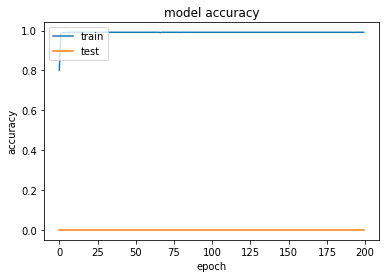

In [22]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [232]:
import sklearn
y_pred = model.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
print(confusion_matrix)

[[920  55]
 [ 32   3]]


In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)

In [23]:
# oh no, it's so accurate because it's predicting every single point as 0!
# that isn't helpful for us, we need some values to be classified at 1 sometimes....
preds = model.predict(X_test)
#preds = np.where(preds > 0.9, 1, 0)
print(preds[0:25])

[[0.07691556]
 [0.16133443]
 [0.12428945]
 [0.13169476]
 [0.11476895]
 [0.1407386 ]
 [0.18420845]
 [0.14248562]
 [0.10652506]
 [0.07117614]
 [0.20214802]
 [0.11795133]
 [0.05355549]
 [0.02588749]
 [0.11692151]
 [0.11815694]
 [0.05374756]
 [0.09990406]
 [0.08466238]
 [0.10129228]
 [0.16003758]
 [0.02803051]
 [0.10145947]
 [0.1118508 ]
 [0.06258085]]
